In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, precision_score, recall_score, make_scorer
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,GridSearchCV, RandomizedSearchCV

Using TensorFlow backend.


In [4]:
from sklearn.linear_model import LogisticRegressionCV

In [5]:
import pysubgroup as ps

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
RANDOM_SEED = 42

Бизнес-задача "Определение фродовых транзакций"
Мы хотим понять, какие транзакции являются мошенническими, а какие "честными".
Сначала нам нужно определить через какую (какие) переменную задаётся задача. В данном случае это Class, бинарная переменная. 0 - честная транзакция, 1 - мошенническая.

In [8]:
db = pd.read_csv('./clean_df.csv')
db = db.drop(columns = ['Unnamed: 0'])
db.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Разделение на test train

In [9]:
#проверим баланс классов
def CheckClassesBalance(Data):
    Fraud_Train = []
    NotFraud_Train = []
    
    for i in Data:
        if i == 1:
            Fraud_Train.append(i)
        else:
            NotFraud_Train.append(i)
        
    print('Fraud: ' + str(len(Fraud_Train)))
    print('Not fraud: ' + str(len(NotFraud_Train)))

In [10]:
def train_test(df, target, random = RANDOM_SEED) :
    DataFeatures = df.drop(columns = [target]).copy()
    DataTarget = df[[target]].copy()

    XTrain,XTest,YTrain,YTest = train_test_split(DataFeatures,DataTarget,stratify = DataTarget, #shuffle (default=True)
                                             test_size = 0.3, random_state = random) 
    #print("Class balance in Train")
    #Y = YTrain[target]
    #CheckClassesBalance(Y)

    
    #print("Class balance in Test")
    #Y = YTest[target]
    #CheckClassesBalance(Y)
    
    
    return XTrain,XTest,YTrain,YTest

In [11]:
XTrain,XTest,YTrain,YTest = train_test(db, 'Class')

In [12]:
db_train = pd.concat([XTrain, YTrain], axis=1)
db_test = pd.concat([XTest, YTest], axis=1)

В этом разделе мы рассмотрим как методы класса SD могут применятся для улучшения предсказательных моделей.

# Определение подгрупп на тренировочной выборке

In [452]:
target = ps.NominalTarget(target_selector=ps.NominalSelector('Class', True))
# Интересует именно класс 1, поэтому True

#нужно определить пространство поиска, т.е. тот набор "вопросов", 
#которые будут "задаваться" данным для определения подгрупп. 
searchSpace = ps.create_selectors(db_train, ignore = ['Class']) 

#создаём задачу, которую затем и исполняем
task = ps.SubgroupDiscoveryTask(
    db_train,
    target=target,
    search_space=searchSpace,
    result_set_size = 5, # на выход получаем 5 подгрупп
    depth = 3, # Каждая подгруппа описывается не более чем 3 предикатами
    qf = ps.ChiSquaredQF()) # Функция качества на базе Chi2

result = ps.BeamSearch().execute(task)

In [453]:
#вывод подгрупп с максимальной оценкой
for (q,sg) in result:
    print(str(q) + ":\t" + str(sg.subgroup_description))

111302.94990868578:	V10<-0.66 AND V4>=0.97 AND V17<-0.57
96515.52413654976:	V14<-0.56 AND V17<-0.57 AND V3<-1.13
84795.45834183213:	V12<-0.57 AND V17<-0.57 AND V11>=0.90
76061.7129902052:	V12<-0.57 AND V17<-0.57 AND V16<-0.61
70162.24811555135:	V12<-0.57 AND V17<-0.57 AND V18<-0.62


In [454]:
#доступ к конкретной подгруппе
sg1 = result[0][1]
#получение массива из True и False - маска наблюдений, попадающих под описание выявленной подгруппы
sg1.covers(db_train)

array([False, False, False, ..., False, False, False])

In [455]:
#доступ к оценке подгруппы на определенном наборе данных
ps.ChiSquaredQF().evaluate_from_dataset(db_train, result[0][1])

111302.94990868578

In [456]:
#подсчет количества наблюдений класса 1, попавших в группу 
((db_train.Class == 1) & (sg1.covers(db_train) == True)).sum()

244

In [457]:
#подсчет количсетва наблюдений, попавших в группу (обоих классов)
(sg1.covers(db_train) == True).sum()

304

### Сбалансированный датасет

In [13]:
def smote(X, Y, random = RANDOM_SEED):
    SMT = SMOTE(random_state = random)
    X_SMOTE,Y_SMOTE = SMT.fit_sample(X,Y.values.ravel()) 
    X_SMOTE = pd.DataFrame(X_SMOTE)
    X_SMOTE.columns = X.columns
    Y_SMOTE = pd.DataFrame(Y_SMOTE)
    Y_SMOTE.columns = ['Class']
    return X_SMOTE, Y_SMOTE

In [14]:
X_SMOTE, Y_SMOTE = smote(XTrain,YTrain)

In [15]:
db_SMOTE = pd.concat([X_SMOTE, Y_SMOTE], axis = 1)
db_SMOTE.shape

(390742, 31)

In [461]:
target = ps.NominalTarget(target_selector=ps.NominalSelector('Class', True))
# Интересует именно класс 1, поэтому True

#нужно определить пространство поиска, т.е. тот набор "вопросов", 
#которые будут "задаваться" данным для определения подгрупп. 
searchSpace1 = ps.create_selectors(db_SMOTE, ignore = ['Class']) 

#создаём задачу, которую затем и исполняем
task1 = ps.SubgroupDiscoveryTask(
    db_SMOTE,
    target=target,
    search_space=searchSpace1,
    result_set_size = 5, # на выход получаем 5 подгрупп
    depth = 3, # Каждая подгруппа описывается не более чем 3 предикатами
    qf = ps.ChiSquaredQF()) # Функция качества на базе Chi2

result1 = ps.BeamSearch().execute(task1)

In [462]:
#вывод подгрупп с максимальной оценкой
for (q,sg) in result1:
    print(str(q) + ":\t" + str(sg.subgroup_description))

97684.87500079977:	V10<-5.32
97684.87500079977:	V12<-6.48
97684.87500079977:	V14<-7.74
97684.87500079977:	V16<-4.21
97684.87500079977:	V17<-6.29


In [463]:
#доступ к конкретной подгруппе
sg2 = result1[0][1]

In [477]:
#подсчет количества наблюдений класса 1, попавших в группу 
((db_SMOTE.Class == 1) & (sg2.covers(db_SMOTE) == True)).sum()

78148

In [478]:
(sg2.covers(db_SMOTE) == True).sum()

78148

In [479]:
(db_SMOTE.Class == 1).sum()

195371

In [480]:
ps.ChiSquaredQF().evaluate_from_dataset(db_SMOTE, result1[0][1])

97684.87500079977

### А если другую метрику качества?

In [468]:
target = ps.NominalTarget(target_selector=ps.NominalSelector('Class', True))
# Интересует именно класс 1, поэтому True

#нужно определить пространство поиска, т.е. тот набор "вопросов", 
#которые будут "задаваться" данным для определения подгрупп. 
searchSpace3 = ps.create_selectors(db_train, ignore = ['Class']) 

#создаём задачу, которую затем и исполняем
task3 = ps.SubgroupDiscoveryTask(
    db_train,
    target=target,
    search_space=searchSpace3,
    result_set_size = 5, # на выход получаем 5 подгрупп
    depth = 3, # Каждая подгруппа описывается не более чем 3 предикатами
    qf = ps.StandardQF(0)) # Функция качества на базе Chi2

#создаём задачу, которую затем и исполняем
task4 = ps.SubgroupDiscoveryTask(
    db_train,
    target=target,
    search_space=searchSpace3,
    result_set_size = 5, # на выход получаем 5 подгрупп
    depth = 3, # Каждая подгруппа описывается не более чем 3 предикатами
    qf = ps.StandardQF(0.5)) # Функция качества на базе Chi2

#создаём задачу, которую затем и исполняем
task5 = ps.SubgroupDiscoveryTask(
    db_train,
    target=target,
    search_space=searchSpace3,
    result_set_size = 5, # на выход получаем 5 подгрупп
    depth = 3, # Каждая подгруппа описывается не более чем 3 предикатами
    qf = ps.StandardQF(1)) # Функция качества на базе Chi2

In [469]:
result3 = ps.BeamSearch().execute(task3)
result4 = ps.BeamSearch().execute(task4)
result5 = ps.BeamSearch().execute(task5)

In [470]:
#вывод подгрупп с максимальной оценкой
for (q,sg) in result3:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.8008739211286013:	V10<-0.66 AND V4>=0.97 AND V17<-0.57
0.6833252151094097:	V14<-0.56 AND V17<-0.57 AND V3<-1.13
0.6670321510984303:	V11>=0.90 AND V17<-0.57 AND V18<-0.62
0.5862053051441958:	V11>=0.90 AND V17<-0.57 AND V12<-0.57
0.5786238135708787:	V12<-0.57 AND V17<-0.57 AND V18<-0.62


In [471]:
#вывод подгрупп с максимальной оценкой
for (q,sg) in result4:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.03156377127855472:	V10<-0.66 AND V4>=0.97 AND V17<-0.57
0.02938797596157355:	V14<-0.56 AND V17<-0.57 AND V3<-1.13
0.027540990905016813:	V12<-0.57 AND V17<-0.57 AND V11>=0.90
0.026080320595362107:	V12<-0.57 AND V17<-0.57 AND V16<-0.61
0.02505631956503811:	V12<-0.57 AND V17<-0.57 AND V18<-0.62


In [472]:
#вывод подгрупп с максимальной оценкой
for (q,sg) in result5:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.0014416179054817276:	V4>=0.97 AND V14<-0.56
0.0014337249661314515:	V11>=0.90 AND V14<-0.56
0.0014214943483893067:	V12<-0.57 AND V14<-0.56
0.0014187158136064178:	V10<-0.66 AND V14<-0.56 AND V12<-0.57
0.0014067018291596639:	V12<-0.57 AND V14<-0.56 AND V11>=0.90


In [484]:
target = ps.NominalTarget(target_selector=ps.NominalSelector('Class', True))
# Интересует именно класс 1, поэтому True

#нужно определить пространство поиска, т.е. тот набор "вопросов", 
#которые будут "задаваться" данным для определения подгрупп. 
searchSpace4 = ps.create_selectors(db_SMOTE, ignore = ['Class']) 

#создаём задачу, которую затем и исполняем
task6 = ps.SubgroupDiscoveryTask(
    db_SMOTE,
    target=target,
    search_space=searchSpace4,
    result_set_size = 5, # на выход получаем 5 подгрупп
    depth = 3, # Каждая подгруппа описывается не более чем 3 предикатами
    qf = ps.StandardQF(0)) # Функция качества на базе Chi2

#создаём задачу, которую затем и исполняем
task7 = ps.SubgroupDiscoveryTask(
    db_SMOTE,
    target=target,
    search_space=searchSpace4,
    result_set_size = 5, # на выход получаем 5 подгрупп
    depth = 3, # Каждая подгруппа описывается не более чем 3 предикатами
    qf = ps.StandardQF(0.5)) # Функция качества на базе Chi2

#создаём задачу, которую затем и исполняем
task8 = ps.SubgroupDiscoveryTask(
    db_SMOTE,
    target=target,
    search_space=searchSpace4,
    result_set_size = 5, # на выход получаем 5 подгрупп
    depth = 3, # Каждая подгруппа описывается не более чем 3 предикатами
    qf = ps.StandardQF(1)) # Функция качества на базе Chi2

In [485]:
result6 = ps.BeamSearch().execute(task6)
result7 = ps.BeamSearch().execute(task7)
result8 = ps.BeamSearch().execute(task8)

In [486]:
#вывод подгрупп с максимальной оценкой
for (q,sg) in result6:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.5:	V10<-5.32
0.5:	V12<-6.48
0.5:	V14<-7.74
0.5:	V16<-4.21
0.5:	V17<-6.29


In [487]:
#вывод подгрупп с максимальной оценкой
for (q,sg) in result7:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.22360622548724837:	V10<-5.32
0.22360622548724837:	V12<-6.48
0.22360622548724837:	V14<-7.74
0.22360622548724837:	V16<-4.21
0.22360622548724837:	V17<-6.29


In [488]:
#вывод подгрупп с максимальной оценкой
for (q,sg) in result8:
    print(str(q) + ":\t" + str(sg.subgroup_description))

0.09999948815330832:	V10<-5.32
0.09999948815330832:	V12<-6.48
0.09999948815330832:	V14<-7.74
0.09999948815330832:	V16<-4.21
0.09999948815330832:	V17<-6.29


### Построение базовой модели

Первым делом строим предсказательную модель - она уже построена - логистическая регрессия и лес после обработки выбросов

In [591]:
def LogReg(X, Y, random = RANDOM_SEED) :
    Model_LogReg = LogisticRegression(random_state = random, max_iter = 1000, class_weight = "balanced")
    return Model_LogReg.fit(X,Y)

In [592]:
def RFC(X, Y, random = RANDOM_SEED) :
    Model_RFC = RandomForestClassifier(random_state = random, n_jobs = -1)
    return Model_RFC.fit(X,Y)

In [593]:
def ETC(X, Y, random = RANDOM_SEED):
    model_etc = ExtraTreesClassifier(n_estimators=100, random_state= random)
    return model_etc.fit(X, Y)


In [492]:
def TestClassification(XTest,YTest, pred):
    
    #предсказание классов на тестовой выборке
    print(classification_report(YTest,pred))
    
    #визуализация результатов работы классификатора
    class_names = ['NotFraud','Fraud']
    Matrix = confusion_matrix(YTest,pred)
    DFCM = pd.DataFrame(Matrix,index =  class_names,columns = class_names)
    sns.heatmap(DFCM,annot = True,cbar = None,cmap = "Blues",fmt = 'g')
    plt.title("Confusion Matrix"),plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     83731
           1       0.06      0.93      0.11       148

    accuracy                           0.97     83879
   macro avg       0.53      0.95      0.55     83879
weighted avg       1.00      0.97      0.99     83879



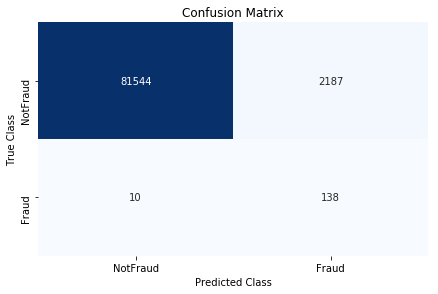

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83731
           1       0.96      0.82      0.89       148

    accuracy                           1.00     83879
   macro avg       0.98      0.91      0.94     83879
weighted avg       1.00      1.00      1.00     83879



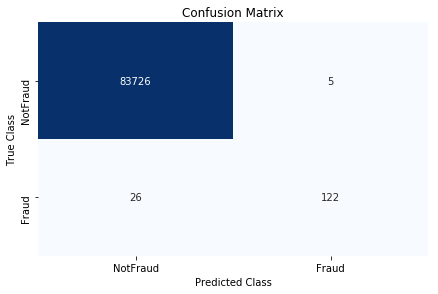

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83731
           1       0.94      0.85      0.89       148

    accuracy                           1.00     83879
   macro avg       0.97      0.93      0.95     83879
weighted avg       1.00      1.00      1.00     83879



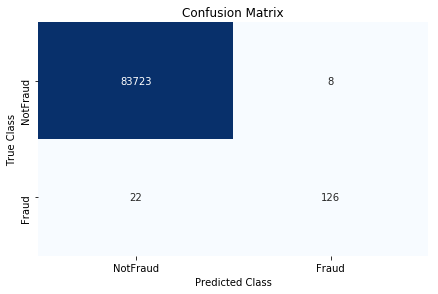

In [493]:
log_reg = LogReg(X_SMOTE,Y_SMOTE)
pred_lg = log_reg.predict(XTest)  #у лог регрессии очень низкий precision для класса 0, 
                                    #мы не можем столько блокировать честных пользователей
TestClassification(XTest, YTest, pred_lg)

Model_RFC = RFC(X_SMOTE,Y_SMOTE)
pred_rf = Model_RFC.predict(XTest)
#у леса низкий recall на 1 классе, нужно его научить распознавать фрод
TestClassification(XTest, YTest, pred_rf)

model_etc = ETC(X_SMOTE,Y_SMOTE)
pred_extra = model_etc.predict(XTest)

TestClassification(XTest, YTest, pred_extra)

### Изучение признаков, сравнение с выявленными паттернами, добавление примитивных признаков

In [494]:
XTrain[['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']].describe()

,V3,V4,V10,V11,V12,V14,V16,V17,V18
count,195715.000000,195715.000000,195715.000000,195715.000000,195715.000000,195715.000000,195715.000000,195715.000000,195715.000000
mean,0.045844,-0.013495,-0.041613,-0.006904,-0.002151,0.007637,-0.003714,-0.002936,0.000490
std,1.404741,1.381634,0.899703,1.008627,0.978514,0.900996,0.856895,0.811005,0.829968
min,-30.558697,-5.683171,-22.187089,-3.684586,-18.683715,-19.214325,-14.129855,-25.162799,-9.335193
25%,-0.852691,-0.846884,-0.534827,-0.764978,-0.402663,-0.417718,-0.465847,-0.482151,-0.495333
50%,0.196897,-0.024014,-0.097768,-0.037866,0.137743,0.050892,0.064539,-0.067133,-0.002939
75%,1.036124,0.728068,0.431163,0.730738,0.614631,0.490617,0.517465,0.394388,0.498274
max,4.226108,12.114672,4.342629,12.018913,3.709133,3.944590,3.620831,8.538195,4.199591


In [495]:
db_trn_smt_feat = X_SMOTE.copy()
db_trn_smt_feat["feat1"] = db_trn_smt_feat.V3 < -1.13
db_trn_smt_feat["feat2"] = db_trn_smt_feat.V4 >= 0.97
db_trn_smt_feat["feat3"] = db_trn_smt_feat.V10 < -0.66
db_trn_smt_feat["feat4"] = db_trn_smt_feat.V11 >= 0.9
db_trn_smt_feat["feat5"] = db_trn_smt_feat.V12 < -0.57
db_trn_smt_feat["feat6"] = db_trn_smt_feat.V14 < -0.56
db_trn_smt_feat["feat7"] = db_trn_smt_feat.V16 < -0.61
db_trn_smt_feat["feat8"] = db_trn_smt_feat.V17 < -0.57
db_trn_smt_feat["feat9"] = db_trn_smt_feat.V18 < -0.62

db_trn_smt_feat["feat10"] = db_trn_smt_feat.V10 < -5.32
db_trn_smt_feat["feat11"] = db_trn_smt_feat.V12 < -6.48
db_trn_smt_feat["feat12"] = db_trn_smt_feat.V14 < -7.74
db_trn_smt_feat["feat13"] = db_trn_smt_feat.V16 < -4.21
db_trn_smt_feat["feat14"] = db_trn_smt_feat.V17 < -6.29
db_trn_smt_feat.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14
0,-0.279606,0.855508,0.094546,0.843062,0.003617,-0.746947,0.737024,-0.734954,0.985991,-0.156746,...,False,False,False,True,False,False,False,False,False,False
1,0.985118,-0.532819,-0.989359,0.782217,1.768106,0.079354,0.124490,-0.518172,1.232854,-0.015548,...,False,False,False,False,False,False,False,False,False,False
2,-0.203731,-0.723223,-0.923256,0.727796,0.083868,-1.414331,2.920978,3.143864,0.330574,0.686421,...,True,False,False,False,False,False,False,False,False,False
3,-0.293440,0.328058,-0.286027,0.550419,0.059840,-0.569128,1.239094,-0.157103,0.664727,0.045654,...,True,False,False,False,False,False,False,False,False,False
4,1.198910,0.647458,2.006178,-0.913547,-1.636275,-1.051496,-0.211255,-0.707509,-0.134137,-0.248002,...,False,False,False,False,True,False,False,False,False,False


In [496]:
db_tst_feat = XTest.copy()
#примитивные признаки
db_tst_feat["feat1"] = db_tst_feat.V3 < -1.13
db_tst_feat["feat2"] = db_tst_feat.V4 >= 0.97
db_tst_feat["feat3"] = db_tst_feat.V10 < -0.66
db_tst_feat["feat4"] = db_tst_feat.V11 >= 0.9
db_tst_feat["feat5"] = db_tst_feat.V12 < -0.57
db_tst_feat["feat6"] = db_tst_feat.V14 < -0.56
db_tst_feat["feat7"] = db_tst_feat.V16 < -0.61
db_tst_feat["feat8"] = db_tst_feat.V17 < -0.57
db_tst_feat["feat9"] = db_tst_feat.V18 < -0.62

db_tst_feat["feat10"] = db_tst_feat.V10 < -5.32
db_tst_feat["feat11"] = db_tst_feat.V12 < -6.48
db_tst_feat["feat12"] = db_tst_feat.V14 < -7.74
db_tst_feat["feat13"] = db_tst_feat.V16 < -4.21
db_tst_feat["feat14"] = db_tst_feat.V17 < -6.29 

db_tst_feat.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14
81921,-0.167819,-0.290828,-0.501581,1.150714,1.747783,0.389926,0.044050,-0.516626,0.755195,-0.047635,...,False,False,False,True,False,False,False,False,False,False
273727,0.064417,0.984222,1.884305,-0.501911,-1.767048,0.466200,2.074711,4.165280,-0.861902,1.077955,...,False,False,False,False,True,False,False,False,False,False
78143,-0.272480,-0.311611,1.273877,0.300214,0.241854,0.989041,-0.147187,-0.594297,0.069147,-0.130465,...,False,False,False,True,False,False,False,False,False,False
232079,0.974499,0.753968,-0.065204,0.301664,-0.522449,-0.060256,0.556208,-1.174568,0.905744,-0.150692,...,True,True,False,False,False,False,False,False,False,False
200877,1.020052,0.595766,1.879271,-0.769030,-0.519117,-0.638952,-0.927761,-0.984685,-0.398467,-0.266529,...,False,False,False,True,False,False,False,False,False,False


/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      0.97      0.98     83731
           1       0.05      0.93      0.10       148

    accuracy                           0.97     83879
   macro avg       0.53      0.95      0.54     83879
weighted avg       1.00      0.97      0.98     83879



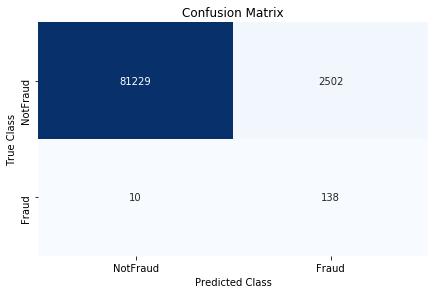

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83731
           1       0.95      0.83      0.88       148

    accuracy                           1.00     83879
   macro avg       0.97      0.92      0.94     83879
weighted avg       1.00      1.00      1.00     83879



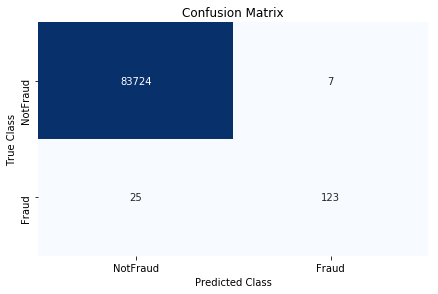

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83731
           1       0.95      0.84      0.89       148

    accuracy                           1.00     83879
   macro avg       0.97      0.92      0.95     83879
weighted avg       1.00      1.00      1.00     83879



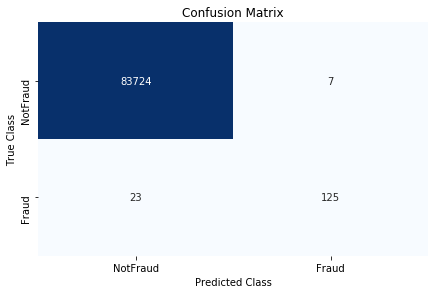

In [497]:
log_reg = LogReg(db_trn_smt_feat,Y_SMOTE)
pred_lg = log_reg.predict(db_tst_feat)

TestClassification(db_tst_feat, YTest, pred_lg)

Model_RFC = RFC(db_trn_smt_feat,Y_SMOTE)
pred_rf = Model_RFC.predict(db_tst_feat)

TestClassification(db_tst_feat, YTest, pred_rf)

model_etc = ETC(db_trn_smt_feat,Y_SMOTE)
pred_extra = model_etc.predict(db_tst_feat)

TestClassification(db_tst_feat, YTest, pred_extra)

In [498]:
#произведения бинарных признаков
db_trn_smt_feat["feat15"] = db_trn_smt_feat.feat8 & db_trn_smt_feat.feat3 #V17 V10
db_trn_smt_feat["feat16"] = db_trn_smt_feat.feat8 & db_trn_smt_feat.feat1 & db_trn_smt_feat.feat6  #V17 V3 V14
db_trn_smt_feat["feat17"] = db_trn_smt_feat.feat8 & db_trn_smt_feat.feat5 #V17 V12
db_trn_smt_feat["feat18"] = db_trn_smt_feat.feat8 & db_trn_smt_feat.feat7 #V17 V16
db_trn_smt_feat["feat19"] = db_trn_smt_feat.feat8 & db_trn_smt_feat.feat9 #V17 V18
db_trn_smt_feat["feat20"] = db_trn_smt_feat.feat5 & db_trn_smt_feat.feat6 #V12 V14
db_trn_smt_feat["feat21"] = db_trn_smt_feat.feat3 & db_trn_smt_feat.feat6 #V10 V14  

#произведения числовых признаков

db_trn_smt_feat["feat22"] = db_trn_smt_feat.V17 * db_trn_smt_feat.V10 #V17 V10
db_trn_smt_feat["feat23"] = db_trn_smt_feat.V17 * db_trn_smt_feat.V3  #V17 V3
db_trn_smt_feat["feat24"] = db_trn_smt_feat.V17 * db_trn_smt_feat.V14  #V17 V14
db_trn_smt_feat["feat25"] = db_trn_smt_feat.V17 * db_trn_smt_feat.V12 #V17 V12
db_trn_smt_feat["feat26"] = db_trn_smt_feat.V17 * db_trn_smt_feat.V16 #V17 V16
db_trn_smt_feat["feat27"] = db_trn_smt_feat.V17 * db_trn_smt_feat.V18 #V17 V18
db_trn_smt_feat["feat28"] = db_trn_smt_feat.V12 * db_trn_smt_feat.V14 #V12 V14
db_trn_smt_feat["feat29"] = db_trn_smt_feat.V10 * db_trn_smt_feat.V14 #V10 V14  

db_trn_smt_feat.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29
0,-0.279606,0.855508,0.094546,0.843062,0.003617,-0.746947,0.737024,-0.734954,0.985991,-0.156746,...,False,False,0.265077,-0.002364,-0.060358,0.096641,-0.073927,0.333372,-0.013658,-0.037463
1,0.985118,-0.532819,-0.989359,0.782217,1.768106,0.079354,0.124490,-0.518172,1.232854,-0.015548,...,False,False,0.192321,-0.388475,-0.089143,0.056326,0.032562,0.112462,-0.104013,-0.355144
2,-0.203731,-0.723223,-0.923256,0.727796,0.083868,-1.414331,2.920978,3.143864,0.330574,0.686421,...,False,False,0.311425,-0.030150,-0.629132,0.975256,-0.250333,0.029535,-4.747563,-1.516024
3,-0.293440,0.328058,-0.286027,0.550419,0.059840,-0.569128,1.239094,-0.157103,0.664727,0.045654,...,False,False,0.320600,-0.030480,-0.468390,0.988360,0.105970,-0.541959,-1.784272,-0.578774
4,1.198910,0.647458,2.006178,-0.913547,-1.636275,-1.051496,-0.211255,-0.707509,-0.134137,-0.248002,...,False,False,-0.021158,0.036016,-0.006607,-0.007305,-0.022085,0.030082,0.099625,0.288546


In [499]:
#произведения бинарных признаков
db_tst_feat["feat15"] = db_tst_feat.feat8 & db_tst_feat.feat3 #V17 V10
db_tst_feat["feat16"] = db_tst_feat.feat8 & db_tst_feat.feat1 & db_tst_feat.feat6  #V17 V3 V14
db_tst_feat["feat17"] = db_tst_feat.feat8 & db_tst_feat.feat5 #V17 V12
db_tst_feat["feat18"] = db_tst_feat.feat8 & db_tst_feat.feat7 #V17 V16
db_tst_feat["feat19"] = db_tst_feat.feat8 & db_tst_feat.feat9 #V17 V18
db_tst_feat["feat20"] = db_tst_feat.feat5 & db_tst_feat.feat6 #V12 V14
db_tst_feat["feat21"] = db_tst_feat.feat3 & db_tst_feat.feat6 #V10 V14  

#произведения числовых признаков

db_tst_feat["feat22"] = db_tst_feat.V17 * db_tst_feat.V10 #V17 V10
db_tst_feat["feat23"] = db_tst_feat.V17 * db_tst_feat.V3  #V17 V3
db_tst_feat["feat24"] = db_tst_feat.V17 * db_tst_feat.V14 #V17 V14
db_tst_feat["feat25"] = db_tst_feat.V17 * db_tst_feat.V12 #V17 V12
db_tst_feat["feat26"] = db_tst_feat.V17 * db_tst_feat.V16 #V17 V16
db_tst_feat["feat27"] = db_tst_feat.V17 * db_tst_feat.V18 #V17 V18
db_tst_feat["feat28"] = db_tst_feat.V12 * db_tst_feat.V14 #V12 V14
db_tst_feat["feat29"] = db_tst_feat.V10 * db_tst_feat.V14 #V10 V14  

db_tst_feat.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29
81921,-0.167819,-0.290828,-0.501581,1.150714,1.747783,0.389926,0.044050,-0.516626,0.755195,-0.047635,...,False,False,0.153980,-1.210313,-0.169588,-0.789944,-0.147012,-0.108802,0.279365,-0.054455
273727,0.064417,0.984222,1.884305,-0.501911,-1.767048,0.466200,2.074711,4.165280,-0.861902,1.077955,...,False,False,0.000194,0.236415,0.008685,-0.099760,0.066357,0.134054,-0.048405,0.000094
78143,-0.272480,-0.311611,1.273877,0.300214,0.241854,0.989041,-0.147187,-0.594297,0.069147,-0.130465,...,False,False,-0.006246,-0.157038,-0.242748,0.102333,-0.225905,-0.035795,-0.058920,0.003596
232079,0.974499,0.753968,-0.065204,0.301664,-0.522449,-0.060256,0.556208,-1.174568,0.905744,-0.150692,...,True,True,-1.753247,-0.650490,-1.784919,-0.859988,-0.052887,0.622575,0.990188,2.018683
200877,1.020052,0.595766,1.879271,-0.769030,-0.519117,-0.638952,-0.927761,-0.984685,-0.398467,-0.266529,...,False,False,0.267414,0.305348,0.196501,-0.700662,-0.102904,0.052299,-0.397934,0.151875


/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      0.97      0.98     83731
           1       0.05      0.92      0.10       148

    accuracy                           0.97     83879
   macro avg       0.53      0.94      0.54     83879
weighted avg       1.00      0.97      0.98     83879



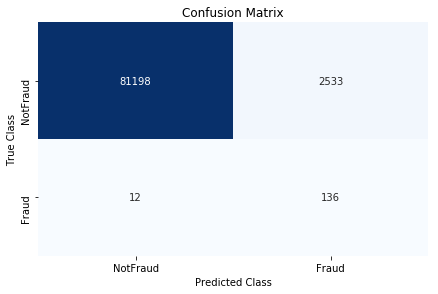

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83731
           1       0.93      0.84      0.88       148

    accuracy                           1.00     83879
   macro avg       0.97      0.92      0.94     83879
weighted avg       1.00      1.00      1.00     83879



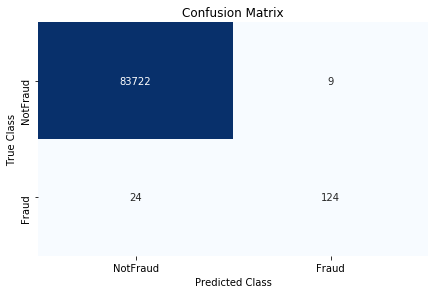

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83731
           1       0.95      0.84      0.90       148

    accuracy                           1.00     83879
   macro avg       0.98      0.92      0.95     83879
weighted avg       1.00      1.00      1.00     83879



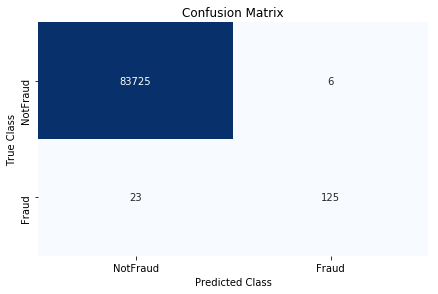

In [500]:
log_reg = LogReg(db_trn_smt_feat,Y_SMOTE)
pred_lg = log_reg.predict(db_tst_feat)

TestClassification(db_tst_feat, YTest, pred_lg)

Model_RFC = RFC(db_trn_smt_feat,Y_SMOTE)
pred_rf = Model_RFC.predict(db_tst_feat)

TestClassification(db_tst_feat, YTest, pred_rf)

model_etc = ETC(db_trn_smt_feat,Y_SMOTE)
pred_extra = model_etc.predict(db_tst_feat)

TestClassification(db_tst_feat, YTest, pred_extra)

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ 1.21985410e+00 -8.18134610e-01  1.45680297e+00  1.04725487e+00
  7.42882225e-01  8.86554036e-01  1.75696444e+00 -8.44268729e-01
 -8.41936872e-01 -6.38984250e-01 -3.13077424e-01 -6.77940740e-01
  7.52824742e-01 -1.07826223e+00 -5.93935542e-01 -1.45689828e+00
  2.09968966e-02 -4.51000837e-01 -4.00078331e-01 -8.38645287e-01
  4.65564745e-01 -1.44218543e+00 -2.38335997e-01  1.19120447e+00
  1.83558225e+00 -1.34714218e-01  4.01749819e-01 -7.15681581e-01
  2.47786321e-01  1.04780449e+00 -1.44535939e+00 -8.93755686e-01
  3.64459414e-01 -4.71364368e-01  5.32791910e-01  1.08939927e+00
 -3.26102254e-02 -5.38079700e-01 -3.48276721e+00  1.78800170e-04
  1.79586874e-04  3.50427478e-04  1.50882310e-04  2.11068599e-04
 -2.82597717e+00 -1.72940818e-01  4.03364101e-01 -1.10936213e+00
  3.88213629e+00 -1.42977679e+00 -1.05939664e+00  4.03675961e-01
  1.57296767e-01  6.12682953e-02  2.90592073e-01  3.10106407e-01
 -3.19299611e-02  1.35647511e-01  3.45382016e-01]


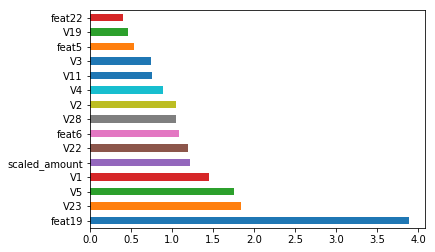

In [501]:
model = LogReg(db_trn_smt_feat,Y_SMOTE)
print(model.coef_[0]) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.coef_[0], index=db_trn_smt_feat.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()
logreg_features = list(feat_importances.nlargest(15).keys())

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[7.66231437e-03 4.81995162e-03 5.96903857e-03 7.72256108e-03
 4.57282588e-03 1.76369026e-02 5.49076481e-03 3.93051036e-03
 5.35432179e-02 1.39492115e-02 4.42015199e-03 7.12119411e-02
 4.51214985e-03 8.40175330e-02 1.07856128e-02 2.56905013e-01
 5.65258156e-03 7.17547458e-03 5.87656526e-03 6.47007322e-03
 5.50428518e-03 7.64688881e-03 4.72475317e-03 3.72083510e-03
 5.80499462e-03 3.30629398e-03 3.27381274e-03 5.68524371e-03
 4.49197127e-03 8.21495804e-03 2.32259251e-03 1.09544728e-02
 3.71338961e-04 2.02553185e-03 2.43551386e-03 6.51424746e-03
 5.39946368e-04 6.53660063e-05 6.47827587e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.65652586e-05 1.07600584e-04 3.47496578e-04 3.86163693e-04
 1.83722653e-05 2.00123405e-04 7.96739471e-02 6.30024160e-02
 8.56301707e-03 7.57448722e-02 2.41708049e-03 8.02938239e-03
 6.26903553e-02 2.13060381e-02 1.69113001e-02]


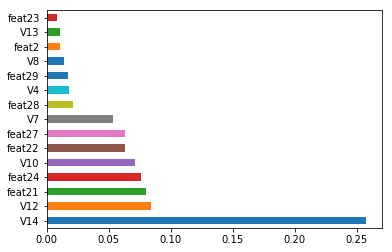

In [502]:
model  = RFC(db_trn_smt_feat,Y_SMOTE)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=db_trn_smt_feat.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()
rfc_features = list(feat_importances.nlargest(15).keys())

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[0.00586309 0.00780862 0.00571774 0.0061765  0.01328444 0.01405031
 0.00440823 0.00650406 0.00513939 0.00520588 0.00554779 0.03088359
 0.00810927 0.02045143 0.00729532 0.02392736 0.00527063 0.00650041
 0.01305711 0.00582866 0.00655289 0.00564243 0.00389525 0.00504464
 0.00375888 0.00409905 0.00388647 0.00597889 0.00277397 0.00310705
 0.02731485 0.05099514 0.01853709 0.03110923 0.02987811 0.08982347
 0.01414248 0.01610934 0.00491607 0.00252987 0.00640071 0.0045324
 0.00258021 0.00375206 0.02426606 0.03867433 0.07338194 0.03061055
 0.00962153 0.13078807 0.07226111 0.00457743 0.00385085 0.01132931
 0.00455742 0.00552181 0.00825275 0.02566438 0.00825206]


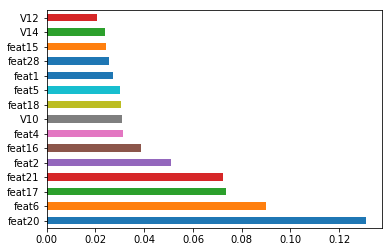

In [503]:
model = ETC(db_trn_smt_feat,Y_SMOTE)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=db_trn_smt_feat.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

clf_features = list(feat_importances.nlargest(15).keys())

### Поиск признаков на ошибках леса

In [504]:
mask = pred_extra == YTest.values.reshape(1, -1)[0]


In [505]:
sum(mask)

83850

In [506]:
final_db = pd.concat([db_tst_feat[~mask], YTest[~mask]], axis = 1)
final_db

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,Class
85599,-0.041361,-0.270750,-1.522305,1.505152,0.372364,2.286869,-0.526519,0.998593,-1.087556,-0.027248,...,False,-0.661588,-1.452779,13.388922,9.039585,12.849812,9.853003,7.951172,-0.581929,1
151399,-0.294557,0.192190,-1.465316,-1.093377,-0.059768,1.064785,11.095089,-5.430971,-9.378025,-0.446456,...,False,2.532821,-0.084764,4.882094,-2.087182,-2.306201,-2.010911,-5.066201,6.147896,1
99501,4.164047,-0.197782,-1.739334,-1.304655,0.314103,0.053740,-0.058696,0.071260,0.694862,-0.313270,...,False,-0.027928,-0.016949,0.023294,0.012863,0.089260,-0.028100,0.102907,-0.223429,1
270927,8.555858,0.964990,-2.027135,-1.131890,-1.135194,1.086963,-0.010547,0.423797,3.790880,-1.155595,...,False,-1.100417,0.936131,-0.275530,0.595412,0.354096,-0.403802,-0.241242,0.445854,1
10305,-0.254454,-0.793066,1.088375,0.898474,0.394684,3.170258,0.175739,-0.221981,-0.022989,-0.010874,...,False,-1.362094,0.907379,-0.759372,-5.856829,0.771641,-0.372659,0.841473,0.195697,1
240734,-0.272899,0.799093,0.051075,1.310427,0.733222,2.620282,1.402358,0.528489,1.086014,-0.146423,...,False,-1.631940,-0.934702,0.181145,-0.555223,-1.055894,-0.171175,-0.061890,-0.181910,1
272679,-0.279606,0.976915,-6.595915,3.303062,-5.993793,1.149137,-3.747111,-1.744032,-4.605288,2.507996,...,True,17.016883,33.177234,4.197195,14.618773,14.495811,7.106001,2.002595,2.331107,0
247181,-0.208761,0.832435,1.878230,1.325630,-2.333469,4.233151,1.355184,-0.853508,0.716025,-0.164910,...,False,0.500495,-4.502078,-5.320291,-0.541227,3.062766,2.294832,0.773559,-0.715341,1
235673,-0.293440,0.773059,1.852889,1.069593,-1.776101,4.617410,0.770413,-0.400859,-0.040970,0.089510,...,False,-1.097283,-5.211936,-12.478780,-4.293753,5.085083,4.217426,6.222237,1.590113,1
610,7.084469,-0.989438,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,...,True,-0.502915,0.652770,-1.014739,-0.301742,0.399879,1.034705,0.851329,1.418913,1


In [564]:
target = ps.NominalTarget(target_selector=ps.NominalSelector('Class', True))
# Интересует именно класс 1, поэтому True

#нужно определить пространство поиска, т.е. тот набор "вопросов", 
#которые будут "задаваться" данным для определения подгрупп. 
searchSpace = ps.create_selectors(final_db, ignore = ['Class']) 

#создаём задачу, которую затем и исполняем
task = ps.SubgroupDiscoveryTask(
    final_db,
    target=target,
    search_space=searchSpace,
    result_set_size = 10, # на выход получаем 5 подгрупп
    depth = 5, # Каждая подгруппа описывается не более чем 3 предикатами
    qf = ps.ChiSquaredQF()) # Функция качества на базе Chi2

result = ps.BeamSearch().execute(task)

In [565]:
#вывод подгрупп с максимальной оценкой
for (q,sg) in result:
    print(str(q) + ":\t" + str(sg.subgroup_description))

18.092260029405587:	V11>=1.55 AND feat10=False
18.092260029405587:	V11>=1.55 AND feat12=False
18.092260029405587:	V11>=1.55 AND feat11=False
18.092260029405587:	V11>=1.55 AND feat6=True
18.092260029405587:	V11>=1.55 AND feat14=False
18.092260029405587:	V11>=1.55 AND feat13=False
18.092260029405587:	V11>=1.55 AND feat4=True
18.092260029405587:	feat26>=5.23
18.092260029405587:	V11>=1.55
18.092260029405587:	feat26>=5.23 AND feat4=True


In [559]:
#доступ к конкретной подгруппе
sg1 = result[0][1]

In [560]:
((final_db.Class == 1) & (sg1.covers(final_db) == True)).sum()

1

In [561]:
(sg1.covers(final_db) == True).sum()

6

In [546]:
db_trn_smt_feat["feat30"] = (db_trn_smt_feat.V11 >= 1.55) & (db_trn_smt_feat.feat10 == False) 
db_trn_smt_feat["feat31"] = (db_trn_smt_feat.V11 >= 1.55) & (db_trn_smt_feat.feat4 == True) 
db_trn_smt_feat["feat32"] = (db_trn_smt_feat.V11 >= 1.55)
db_trn_smt_feat["feat33"] = db_trn_smt_feat.feat26 >= 5.23 
db_trn_smt_feat["feat34"] = (db_trn_smt_feat.V11 >= 1.55) & (db_trn_smt_feat.feat6 == True) 

In [547]:
db_tst_feat["feat30"] = (db_tst_feat.V11 >= 1.55) & (db_tst_feat.feat10 == False) 
db_tst_feat["feat31"] = (db_tst_feat.V11 >= 1.55) & (db_tst_feat.feat4 == True) 
db_tst_feat["feat32"] = (db_tst_feat.V11 >= 1.55)
db_tst_feat["feat33"] = db_tst_feat.feat26 >= 5.23 
db_tst_feat["feat34"] = (db_tst_feat.V11 >= 1.55) & (db_tst_feat.feat6 == True) 

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      0.97      0.98     83731
           1       0.05      0.92      0.10       148

    accuracy                           0.97     83879
   macro avg       0.53      0.94      0.54     83879
weighted avg       1.00      0.97      0.98     83879



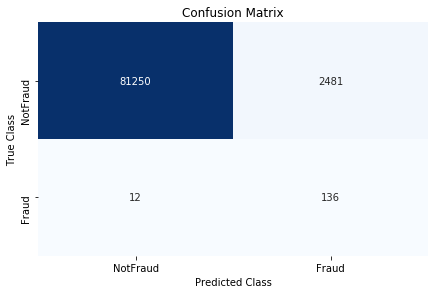

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83731
           1       0.96      0.84      0.90       148

    accuracy                           1.00     83879
   macro avg       0.98      0.92      0.95     83879
weighted avg       1.00      1.00      1.00     83879



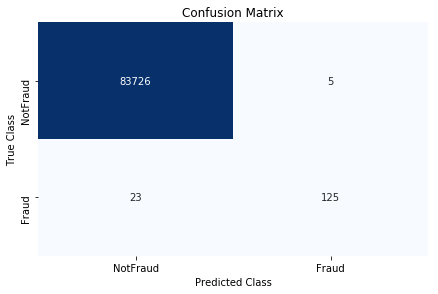

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     83731
           1       0.95      0.85      0.90       148

    accuracy                           1.00     83879
   macro avg       0.98      0.93      0.95     83879
weighted avg       1.00      1.00      1.00     83879



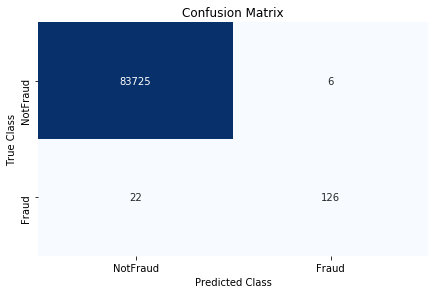

In [548]:
log_reg = LogReg(db_trn_smt_feat,Y_SMOTE)
pred_lg = log_reg.predict(db_tst_feat)

TestClassification(db_tst_feat, YTest, pred_lg)

Model_RFC = RFC(db_trn_smt_feat,Y_SMOTE)
pred_rf = Model_RFC.predict(db_tst_feat)

TestClassification(db_tst_feat, YTest, pred_rf)

model_etc = ETC(db_trn_smt_feat,Y_SMOTE)
pred_extra = model_etc.predict(db_tst_feat)

TestClassification(db_tst_feat, YTest, pred_extra)

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ 1.31721037e+00 -7.95280725e-01  1.52970871e+00  1.17658750e+00
  8.14548169e-01  8.40679519e-01  1.87897180e+00 -8.84777556e-01
 -9.33243941e-01 -6.03504901e-01 -2.61323126e-01 -6.66659654e-01
  8.81982099e-01 -1.05691404e+00 -5.57865185e-01 -1.44699621e+00
  4.26415278e-02 -5.38267596e-01 -2.10911690e-01 -7.71324588e-01
  4.16714469e-01 -1.55484912e+00 -2.72120057e-01  1.18643523e+00
  1.89739877e+00 -1.23856913e-01  4.38858131e-01 -6.23814674e-01
  3.01175459e-01  1.15400778e+00 -1.51473302e+00 -8.49469119e-01
  2.56921618e-01 -3.19150987e-01  5.69285732e-01  1.00010080e+00
 -8.88364021e-02 -2.11984855e-01 -3.38062066e+00  1.77742311e-04
  1.77679135e-04  3.45851002e-04  1.49897485e-04  2.09684230e-04
 -2.93990188e+00 -2.56275783e-01  3.91402658e-01 -1.25651465e+00
  3.98263377e+00 -1.29249982e+00 -1.04558517e+00  3.76793725e-01
  1.58713967e-01  1.19344727e-01  3.72950989e-01  3.90779750e-01
 -1.65614527e-02  1.23993125e-01  3.39681808e-01 -8.98327042e-01
 -8.98149300e-01 -8.98149

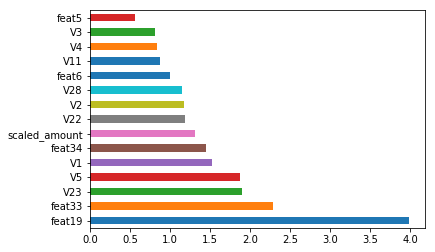

In [549]:
model = LogReg(db_trn_smt_feat,Y_SMOTE)
print(model.coef_[0]) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.coef_[0], index=db_trn_smt_feat.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()
logreg_features = list(feat_importances.nlargest(15).keys())

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[6.57287480e-03 5.44913471e-03 7.66509449e-03 7.44506132e-03
 4.70058811e-03 3.00772812e-02 4.87694657e-03 4.01553532e-03
 6.21357796e-03 1.49663703e-02 4.07422464e-03 7.21448734e-02
 6.59926230e-03 1.41633017e-02 1.20418779e-02 1.18852890e-02
 4.49795066e-03 3.96413206e-03 8.50850961e-03 9.41649287e-03
 7.44412373e-03 5.94100201e-03 5.29568142e-03 4.40055257e-03
 5.36956908e-03 2.52810910e-03 4.39427814e-03 5.23207417e-03
 4.90253305e-03 6.60487464e-03 2.05913293e-03 1.01730767e-02
 5.14411207e-04 1.72517059e-03 1.01439715e-03 5.92544791e-03
 6.31611022e-04 1.26656424e-04 6.53434850e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.57333099e-05 7.56807981e-06 2.40550984e-04 5.51937964e-05
 1.45205196e-04 6.76665923e-02 6.78283595e-04 4.85410467e-03
 1.23351686e-01 1.65905237e-02 1.88271154e-03 1.42716356e-01
 1.03171338e-02 2.17398385e-01 9.90815527e-02 2.91941760e-05
 1.80842035e-05 1.32706009e-05 1.30452048e-05 6.60308643e-04]


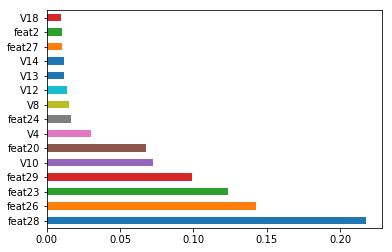

In [550]:
model  = RFC(db_trn_smt_feat,Y_SMOTE)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=db_trn_smt_feat.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()
rfc_features = list(feat_importances.nlargest(15).keys())

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[5.76271763e-03 6.83115403e-03 5.83280625e-03 5.78086080e-03
 6.79577699e-03 1.69704244e-02 5.13196119e-03 3.77724870e-03
 5.04583720e-03 5.09998279e-03 5.15177689e-03 1.18939662e-02
 9.26034010e-03 1.33125921e-02 6.93411406e-03 4.04083276e-02
 5.49913555e-03 5.59243913e-03 9.96671332e-03 5.68088909e-03
 6.24535293e-03 4.95328302e-03 3.59125406e-03 5.22263063e-03
 3.34312818e-03 4.10672070e-03 4.28062591e-03 5.70261574e-03
 2.55031902e-03 2.69004724e-03 1.08375562e-02 3.46038618e-02
 1.39901563e-02 2.18321826e-02 1.89966946e-02 5.03009473e-02
 8.42353801e-03 3.23324641e-03 5.27321494e-03 2.28963570e-05
 2.56200459e-03 2.84461633e-03 6.69583534e-05 2.56706044e-03
 1.86223693e-02 4.00404570e-02 8.19934529e-02 2.70243577e-02
 7.22598532e-04 1.29314656e-01 6.70159061e-02 4.48888000e-03
 3.56621049e-03 8.55793512e-03 3.01122174e-03 4.77207045e-03
 5.21437153e-03 1.54192239e-02 1.03938988e-02 1.09430494e-03
 3.60503312e-02 1.72493237e-02 2.41633270e-02 1.02315128e-01]


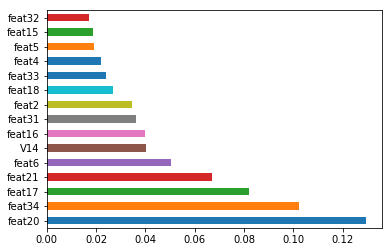

In [551]:
model = CLF(db_trn_smt_feat,Y_SMOTE)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=db_trn_smt_feat.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

clf_features = list(feat_importances.nlargest(15).keys())

In [571]:
#кросс валидация
#каждую из 3 моделей прогнать по 10 раз:
#5 на обычных признаках
#5 на добавленных признаках
#сравнить средний precision recall (4) параметра
#запомнить каждое из 4 значений внутри матрицы

#посчитать экономический эффект

In [588]:
cv_Num = 10
cv_prop = 0.5
cv_n_select = 5000

In [582]:
#два отдельных датасета
dataset = db.copy()
dataset_features = db.copy()

In [583]:
#примитивные признаки
dataset_features["feat1"] = dataset_features.V3 < -1.13
dataset_features["feat2"] = dataset_features.V4 >= 0.97
dataset_features["feat3"] = dataset_features.V10 < -0.66
dataset_features["feat4"] = dataset_features.V11 >= 0.9
dataset_features["feat5"] = dataset_features.V12 < -0.57
dataset_features["feat6"] = dataset_features.V14 < -0.56
dataset_features["feat7"] = dataset_features.V16 < -0.61
dataset_features["feat8"] = dataset_features.V17 < -0.57
dataset_features["feat9"] = dataset_features.V18 < -0.62

dataset_features["feat10"] = dataset_features.V10 < -5.32
dataset_features["feat11"] = dataset_features.V12 < -6.48
dataset_features["feat12"] = dataset_features.V14 < -7.74
dataset_features["feat13"] = dataset_features.V16 < -4.21
dataset_features["feat14"] = dataset_features.V17 < -6.29 


#произведения бинарных признаков
dataset_features["feat15"] = dataset_features.feat8 & dataset_features.feat3 #V17 V10
dataset_features["feat16"] = dataset_features.feat8 & dataset_features.feat1 & dataset_features.feat6  #V17 V3 V14
dataset_features["feat17"] = dataset_features.feat8 & dataset_features.feat5 #V17 V12
dataset_features["feat18"] = dataset_features.feat8 & dataset_features.feat7 #V17 V16
dataset_features["feat19"] = dataset_features.feat8 & dataset_features.feat9 #V17 V18
dataset_features["feat20"] = dataset_features.feat5 & dataset_features.feat6 #V12 V14
dataset_features["feat21"] = dataset_features.feat3 & dataset_features.feat6 #V10 V14  

#произведения числовых признаков

dataset_features["feat22"] = dataset_features.V17 * dataset_features.V10 #V17 V10
dataset_features["feat23"] = dataset_features.V17 * dataset_features.V3  #V17 V3
dataset_features["feat24"] = dataset_features.V17 * dataset_features.V14 #V17 V14
dataset_features["feat25"] = dataset_features.V17 * dataset_features.V12 #V17 V12
dataset_features["feat26"] = dataset_features.V17 * dataset_features.V16 #V17 V16
dataset_features["feat27"] = dataset_features.V17 * dataset_features.V18 #V17 V18
dataset_features["feat28"] = dataset_features.V12 * dataset_features.V14 #V12 V14
dataset_features["feat29"] = dataset_features.V10 * dataset_features.V14 #V10 V14  

dataset_features["feat30"] = (dataset_features.V11 >= 1.55) & (dataset_features.feat10 == False) 
dataset_features["feat31"] = (dataset_features.V11 >= 1.55) & (dataset_features.feat4 == True) 
dataset_features["feat32"] = (dataset_features.V11 >= 1.55)
dataset_features["feat33"] = dataset_features.feat26 >= 5.23 
dataset_features["feat34"] = (dataset_features.V11 >= 1.55) & (dataset_features.feat6 == True)


dataset_features["feat30"] = (dataset_features.V11 >= 1.55) & (dataset_features.feat10 == False) 
dataset_features["feat31"] = (dataset_features.V11 >= 1.55) & (dataset_features.feat4 == True) 
dataset_features["feat32"] = (dataset_features.V11 >= 1.55)
dataset_features["feat33"] = dataset_features.feat26 >= 5.23 
dataset_features["feat34"] = (dataset_features.V11 >= 1.55) & (dataset_features.feat6 == True) 

In [585]:
from tqdm import tqdm

In [609]:
result = pd.DataFrame(None, columns=["model", "report", "confusion"])

for i in tqdm(range(cv_Num)):
    # Разбиение на train-test
    XTrain,XTest,YTrain,YTest = train_test(dataset, 'Class', random = None)
    X_SMOTE, Y_SMOTE = smote(XTrain,YTrain, random = None)
    

    # Обучение
    Model_LR = LogReg(X_SMOTE,Y_SMOTE, random = None)
    pred_LR = Model_LR.predict(XTest)

    #предсказание классов на тестовой выборке
    report = classification_report(YTest,pred_LR, output_dict = True)
    tn, fp, fn, tp = confusion_matrix(YTest,pred_LR).ravel()
    #добавление в датафрейм
    result = result.append({"model": "LogReg", "report": report, "confusion": (tn, fp, fn, tp)}, ignore_index=True)
    
    # Обучение
    Model_RFC = RFC(X_SMOTE,Y_SMOTE, random = None)
    pred_rf = Model_RFC.predict(XTest)

    #предсказание классов на тестовой выборке
    report = classification_report(YTest,pred_rf, output_dict = True)
    tn, fp, fn, tp = confusion_matrix(YTest,pred_rf).ravel()
    #добавление в датафрейм
    result = result.append({"model": "RF", "report": report, "confusion": (tn, fp, fn, tp)}, ignore_index=True)
    
    # Обучение
    Model_ETC = ETC(X_SMOTE,Y_SMOTE, random = None)
    pred_etc = Model_ETC.predict(XTest)

    #предсказание классов на тестовой выборке
    report = classification_report(YTest,pred_etc, output_dict = True)
    tn, fp, fn, tp = confusion_matrix(YTest,pred_etc).ravel()
    #добавление в датафрейм
    result = result.append({"model": "ETC", "report": report, "confusion": (tn, fp, fn, tp)}, ignore_index=True)
    
    





  0%|          | 0/10 [00:00<?, ?it/s]/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until



 60%|██████    | 6/10 [09:01<05:55, 88.95s/it]/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value

In [610]:
result_feat = pd.DataFrame(None, columns=["model", "report", "confusion"])

for i in tqdm(range(cv_Num)):
    # Разбиение на train-test
    XTrain,XTest,YTrain,YTest = train_test(dataset_features, 'Class', random = None)
    X_SMOTE, Y_SMOTE = smote(XTrain,YTrain, random = None)
    

    # Обучение
    Model_LR = LogReg(X_SMOTE,Y_SMOTE, random = None)
    pred_LR = Model_LR.predict(XTest)

    #предсказание классов на тестовой выборке
    report = classification_report(YTest,pred_LR, output_dict = True)
    tn, fp, fn, tp = confusion_matrix(YTest,pred_LR).ravel()
    #добавление в датафрейм
    result_feat = result_feat.append({"model": "LogReg", "report": report, "confusion": (tn, fp, fn, tp)}, ignore_index=True)
    
    # Обучение
    Model_RFC = RFC(X_SMOTE,Y_SMOTE, random = None)
    pred_rf = Model_RFC.predict(XTest)

    #предсказание классов на тестовой выборке
    report = classification_report(YTest,pred_rf, output_dict = True)
    tn, fp, fn, tp = confusion_matrix(YTest,pred_rf).ravel()
    #добавление в датафрейм
    result_feat = result_feat.append({"model": "RF", "report": report, "confusion": (tn, fp, fn, tp)}, ignore_index=True)
    
    # Обучение
    Model_ETC = ETC(X_SMOTE,Y_SMOTE, random = None)
    pred_etc = Model_ETC.predict(XTest)

    #предсказание классов на тестовой выборке
    report = classification_report(YTest,pred_etc, output_dict = True)
    tn, fp, fn, tp = confusion_matrix(YTest,pred_etc).ravel()
    #добавление в датафрейм
    result_feat = result_feat.append({"model": "ETC", "report": report, "confusion": (tn, fp, fn, tp)}, ignore_index=True)
    
    






  0%|          | 0/10 [00:00<?, ?it/s]/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until



 60%|██████    | 6/10 [11:04<07:30, 112.59s/it]/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/elviraneganova/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default valu

In [619]:
result['report'][0]['0']['precision'] #путь до конкретного пресижина

float

In [627]:
result['confusion'][0][0] #0 - tn, 1 - fp, 2 - fn, 3 - tp

81686

In [630]:
prec0 = []
rec0 = []
prec1 = []
rec1 = []
tn = []
fp = []
fn = []
tp = []
for i in tqdm(range(len(result))) :
    prec0.append(result['report'][i]['0']['precision'])
    rec0.append(result['report'][i]['0']['recall'])
    prec1.append(result['report'][i]['1']['precision'])
    rec1.append(result['report'][i]['1']['recall'])
    tn.append(result['confusion'][i][0]) #0 - tn, 1 - fp, 2 - fn, 3 - tp
    fp.append(result['confusion'][i][1]) 
    fn.append(result['confusion'][i][2]) 
    tp.append(result['confusion'][i][3]) 




  0%|          | 0/30 [00:00<?, ?it/s]


100%|██████████| 30/30 [00:00<00:00, 3080.42it/s]

In [635]:
result["precision0"] = prec0
result["recall0"] = rec0
result["precision1"] = prec1
result["recall1"] = rec1
result["tn"] = tn
result["fp"] = fp
result["fn"] = fn
result["tp"] = tp
result = result.drop(columns = ['report', 'confusion'])

In [702]:
prec0 = []
rec0 = []
prec1 = []
rec1 = []
tn = []
fp = []
fn = []
tp = []
for i in tqdm(range(len(result_feat))) :
    prec0.append(result_feat['report'][i]['0']['precision'])
    rec0.append(result_feat['report'][i]['0']['recall'])
    prec1.append(result_feat['report'][i]['1']['precision'])
    rec1.append(result_feat['report'][i]['1']['recall'])
    tn.append(result_feat['confusion'][i][0]) #0 - tn, 1 - fp, 2 - fn, 3 - tp
    fp.append(result_feat['confusion'][i][1]) 
    fn.append(result_feat['confusion'][i][2]) 
    tp.append(result_feat['confusion'][i][3]) 




  0%|          | 0/30 [00:00<?, ?it/s]


100%|██████████| 30/30 [00:00<00:00, 3003.87it/s]

In [703]:
result_feat["precision0"] = prec0
result_feat["recall0"] = rec0
result_feat["precision1"] = prec1
result_feat["recall1"] = rec1
result_feat["tn"] = tn
result_feat["fp"] = fp
result_feat["fn"] = fn
result_feat["tp"] = tp
result_feat = result_feat.drop(columns = ['report', 'confusion'])

In [705]:
result.groupby(['model']).mean()

,precision0,recall0,precision1,recall1,tn,fp,fn,tp
model,,,,,,,,
ETC,0.999704,0.999908,0.941530,0.832432,83723.3,7.7,24.8,123.2
LogReg,0.999833,0.974362,0.059071,0.908108,81584.3,2146.7,13.6,134.4
RF,0.999667,0.999902,0.936455,0.811486,83722.8,8.2,27.9,120.1


In [704]:
result_feat.groupby(['model']).mean()

,precision0,recall0,precision1,recall1,tn,fp,fn,tp
model,,,,,,,,
ETC,0.999675,0.999914,0.944319,0.816216,83723.8,7.2,27.2,120.8
LogReg,0.999804,0.970451,0.051016,0.892568,81256.8,2474.2,15.9,132.1
RF,0.999660,0.999936,0.956998,0.807432,83725.6,5.4,28.5,119.5
